<a href="https://colab.research.google.com/github/mahdiislam79/ViT-Implementation/blob/main/ViT_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Getting Setup

In [11]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [12]:
# continue with regular imports 
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
  from torchinfo import summary
except:
  print(f"[INFO] Couldn't find torchinfo. Installing it.")
  !pip install -q torchinfo
  from torchinfo import summary


In [13]:
# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 1. Get Data

In [15]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [16]:
# Setup directory paths to train and test images
train_dir = image_path / 'train'
test_dir = image_path / 'test'

 # 2. Create Datasets and DataLoaders

Now we've got some data, let's now turn it into `DataLoader`'s.

To do so we can use the `create_dataloaders()` function in [`data_setup.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/data_setup.py).

First, we'll create a transform to prepare our images.

This where one of the first references to the ViT paper will come in.

In Table 3, the training resolution is mentioned as being 224 (height=224, width=224). 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-image-size-and-batch-size.png" width=900 alt="Table 3 from the Vision Transformer paper showing the image size and batch size"/>

*You can often find various hyperparameter settings listed in a table. In this case we're still preparing our data, so we're mainly concerned with things like image size and batch size. Source: Table 3 in [ViT paper](https://arxiv.org/abs/2010.11929).*

# 2.1 Prepare transform for images

In [17]:
# Create image size (from Table 3 in the ViT paper)
Img_Size = 224

# Create transform pipeline manually 
manual_transforms = transforms.Compose([
      transforms.Resize((Img_Size, Img_Size)),
      transforms.ToTensor(),
])
print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


# 2.2 Turn Images into Dataloader's

In [18]:
# Set the batch size 
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fca81a10610>,
 ['pizza', 'steak', 'sushi'])

# 2.3 Visualize a single image

In [19]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

(-0.5, 223.5, 223.5, -0.5)

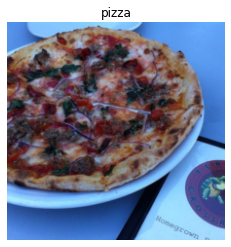

In [20]:
# plot image in matplotlib 
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

# 3. Replicating the ViT paper: an overview